# Regularization

Regularization involves adding a penalty term to our loss function. It turns out that this penalty term can help combat overfitting by making the model more biased but with less variance.

## What we will accomplish

In this notebook we will:
- Introduce the general idea behind regularization,
- Discuss ridge and lasso regression as particular regularization algorithms
- Discuss how ridge can combat multicollinearity.
- Show how lasso is nice for feature selection.

##### Quick Note

This notebook is a little math heavy, I will do my best to provide both mathematical insight for those that want it and give a broad overview for those that do not want to delve too much into the math specifics.

In [1]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## Coefficient explosions

Let's return to our example from the `Bias-Variance Tradeoff` notebook.

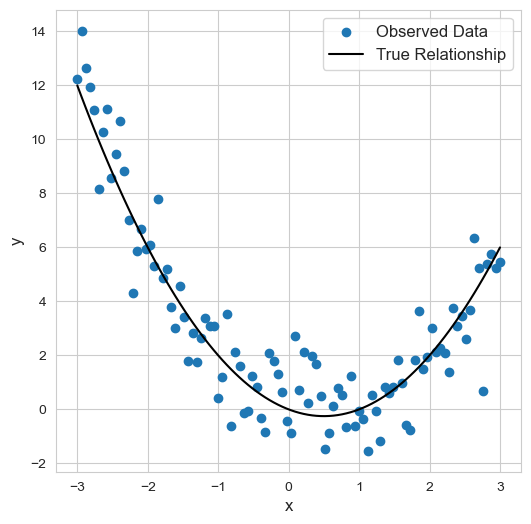

In [2]:
rng = np.random.default_rng(216)
## Generate data
x = np.linspace(-3,3,100)
y = x*(x-1) + 1.2*rng.standard_normal(100)


## plot the data alongside the true relationship
plt.figure(figsize = (6,6))

plt.scatter(x,y, label="Observed Data")

plt.plot(x,x*(x-1),'k', label="True Relationship")

plt.xlabel("x",fontsize=12)
plt.ylabel("y",fontsize=12)

plt.legend(fontsize=12)

plt.show()

In [3]:
## Import the functions/objects we'll need
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [4]:
## Make an array of zeros that will hold some data for me
n = 26
coef_holder = np.zeros((n,n))

## Now we'll fit the data with polynomials degree 1 through n
for i in range(1,n+1):
    ## Make a pipe
    pipe = Pipeline([('poly',PolynomialFeatures(i,include_bias = False)),
                    ('reg',LinearRegression())])
    
    ## fit the data
    pipe.fit(x.reshape(-1,1),y)
    
    ## store the coefficient estimates
    coef_holder[i-1,:i] = np.round(pipe['reg'].coef_,3)

In [5]:
## Display the coefficient estimates as a dataframe
pd.DataFrame(coef_holder, 
             columns = ["x^" + str(i) for i in range(1,n+1)],
            index = [str(i) + "_deg_poly" for i in range(1,n+1)])

,x^1,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10,...,x^17,x^18,x^19,x^20,x^21,x^22,x^23,x^24,x^25,x^26
1_deg_poly,-1.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
2_deg_poly,-1.108,0.991,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
3_deg_poly,-0.829,0.991,-0.051,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
4_deg_poly,-0.829,0.732,-0.051,0.033,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
5_deg_poly,-0.826,0.732,-0.052,0.033,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
6_deg_poly,-0.826,0.319,-0.052,0.168,0.000,-0.011,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
7_deg_poly,-0.715,0.319,-0.161,0.168,0.026,-0.011,-0.002,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
8_deg_poly,-0.715,-0.308,-0.161,0.544,0.026,-0.082,-0.002,0.004,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
9_deg_poly,-0.304,-0.308,-0.820,0.544,0.307,-0.082,-0.046,0.004,0.002,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
10_deg_poly,-0.304,-1.077,-0.820,1.272,0.307,-0.321,-0.046,0.036,0.002,-0.001,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0


<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
/var/folders/14/6_njfgsd63b_nr13v4mq3fb00000gn/T/ipykernel_53389/1386107329.py:9: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("Length of $\hat{\\beta}$", fontsize=12)


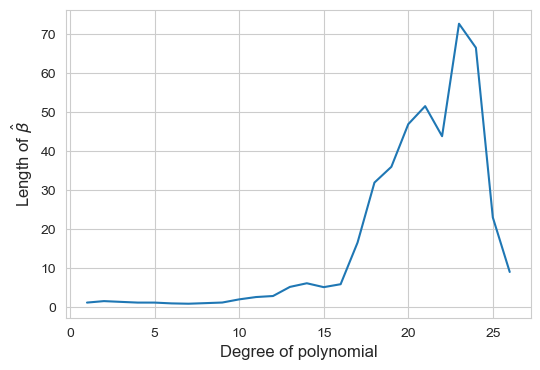

In [6]:
beta_norms = []

for i in range(n):
    beta_norms.append(np.linalg.norm(coef_holder[i,:]))

plt.figure(figsize=(6,4))

plt.plot(range(1,n+1), beta_norms)
plt.ylabel("Length of $\hat{\\beta}$", fontsize=12)
plt.xlabel("Degree of polynomial", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

Looking at the dataframe we have just produced we can notice that a number of our coefficients get larger in magnitude as the model gets more complex. 

This observation leads to the main idea behind regularization.

## The idea behind regularization

Suppose the non-intercept coefficients from the regression are denoted by $\beta$, i.e. $\beta=\left(\beta_1,\beta_2,\dots,\beta_p\right)^T$. Recall that in Ordinary Least Squares regression our goal is to estimate $\beta$ so that

$$
MSE = \frac{1}{n}(y - X\beta - \beta_0)^T(y - X\beta - \beta_0)
$$

is minimized on the training data. <i>Note here that I havve separated the intercept $\beta_0$ from the remaining coefficients, so $X$ is not assumed to have a column of $1$ in this notebook.</i>

The main idea behind regularization is to still minimize the MSE, BUT while also ensuring that $\beta$ doesn't get too large. 

#### Penalizing large parameters

We can modify our loss function to penalize "large" parameters. 

$$
||y-X\beta - \beta_0||^2_2 + \alpha\operatorname{Size}(\beta)
$$

Here $\alpha$ is an adjustable constant which we will call a <i>hyperparameter</i>: a parameter we set before fitting the model.  Different ways of measuring the size of a vector lead to different regularization methods.

For $\alpha=0$ we recover the OLS estimate for $\beta$, for $\alpha=\infty$ we get $\beta=0$, values of $\alpha$ between those two extremes will give different coefficient estimates. The value of $\alpha$ that gives the best model for your data depends on the problem and can be found through cross-validation model comparisons.

## Specific regularization models

<i>Ridge regression</i> and <i>lasso</i> are two forms of regularization where we make specific choices of how to measure the "size" of the parameters.

### Ridge regression

In ridge regression we use the the size of $\beta$ as the square of the Euclidean length (or "$\ell_2$-norm") of $\beta$:

$$
\operatorname{Size}_{\textrm{Ridge}}(\beta) = ||\beta||^2_2 = \beta_1^2 + \beta_2^2 + \dots + \beta_p^2.
$$

This is the length you get using the Pythogorean Theorem!

### Lasso regression

In lasso regression we take $\operatorname{Size}(\beta)$ to be the $\ell_1$-norm:

$$
\operatorname{Size}_{\textrm{Lasso}}(\beta)  = ||\beta||_1 = |\beta_1| + |\beta_2| + \dots + |\beta_p|.
$$

### Some geometric intuition

<p float="left">
  <img src="lecture_assets/ridge.png" width="600" />
  <img src="lecture_assets/lasso.png" width="618" />
</p>

On the left we see a picture of contour lines (in blue) for the MSE of a particular linear regression problem with two features.  The purple circles are the contours of the $\ell_2$ norm.  The OLS estimate, which minimizes the MSE alone, is at the center of all of the ellipses.  The origin minimizes the $\ell_2$ norm.  Ridge regression gives us a "tug of war" between these two quantities. Note that a ridge regression solution $\hat{\beta}_\alpha$ must be at a point of tangency:  if it were at a point of transverse intersection between contours you could move along one contour while decreasing the other.  We can see some different ridge estimates here:  the small $\alpha$ are close to the OLS estimates, while large $\alpha$ is close to the origin.

We get a similar picture for Lasso regression, but the contours of the $\ell_1$ norm are squares instead of circles!  The same argument about tangency applies *until* we intersect a coordinate axis.  Notice that it is clear, from this picture, that the $\hat{\beta}_\alpha$ must follow a **piecewise linear** path as we vary $\alpha$ (a fact which has some cool applications)!

We can also see that while Ridge regression will never zero out a parameter, Lasso will!  In this way, Lasso can be used for "automatic feature selection". 

Let's see this play out by fitting a degree $10$ polynomial our data using both Ridge and Lasso regression and seeing how the coefficients change as we adjust $\alpha$.

### Implementing in `sklearn`

We can implement both of these models in `sklearn` with `Ridge` <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html</a> for ridge regression and `Lasso` <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html</a> for lasso regression.

<i>Note: ridge and lasso regression are examples of algorithms/models where scaling the data is a step that should be taken prior to fitting the model. This is because vastly different scales can impact the scales of the components of $\beta$. This can make it so that there is not enough room in the $\beta$-budget to afford the actual values of the individual coefficients.</i>

In [7]:
## Import the models here
## Ridge and Lasso regression are stored in linear_model

from sklearn.linear_model import Ridge, Lasso


In [8]:
## This code will allow us to demonstrate the effect of 
## increasing alpha

## set values for alpha
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

## The degree of the polynomial we will fit
n=10

#$ These will hold our coefficient estimates
ridge_coefs = np.empty((len(alpha),n))
lasso_coefs = np.empty((len(alpha),n))

## for each alpha value
for i in range(len(alpha)):
    ## set up the ridge pipeline
    ## first scale
    ## then make polynomial features
    ## then fit the ridge regression model
    ridge_pipe = Pipeline([('scale',StandardScaler()),
                              ('poly',PolynomialFeatures(n, interaction_only=False, include_bias=False)),
                              ('ridge', Ridge(alpha=alpha[i], max_iter=5000000))
                              ])
    
    ## set up the lasso pipeline
    ## same steps as with ridge
    lasso_pipe = Pipeline([('scale',StandardScaler()),
                              ('poly',PolynomialFeatures(n, interaction_only=False, include_bias=False)),
                              ('lasso', Lasso(alpha=alpha[i], max_iter=5000000))
                          ])
    
    ## fit the ridge
    ridge_pipe.fit(x.reshape(-1,1), y)
    
    ## fit the lasso
    lasso_pipe.fit(x.reshape(-1,1), y)

    
    # record the coefficients
    ridge_coefs[i,:] = ridge_pipe['ridge'].coef_
    lasso_coefs[i,:] = lasso_pipe['lasso'].coef_

In [9]:
print("Ridge Coefficients")

pd.DataFrame(np.round(ridge_coefs,8),
            columns = ["x^" + str(i) for i in range(1,n+1)],
            index = ["alpha=" + str(a) for a in alpha])

Ridge Coefficients


,x^1,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10
alpha=1e-05,-0.532096,-3.291722,-4.387906,11.909853,5.025352,-9.183685,-2.281569,3.139858,0.345949,-0.391730
alpha=0.0001,-0.534826,-3.258441,-4.375907,11.821701,5.010790,-9.100585,-2.274959,3.107628,0.344945,-0.387338
alpha=0.001,-0.561268,-2.953679,-4.259673,11.014577,4.869705,-8.339812,-2.210916,2.812591,0.335212,-0.347132
alpha=0.01,-0.760828,-1.358686,-3.380449,6.796907,3.801530,-4.369169,-1.725795,1.274186,0.261468,-0.137647
alpha=0.1,-1.228197,0.381332,-1.262057,2.294823,1.199363,-0.208024,-0.537202,-0.314194,0.080159,0.076043
alpha=1,-1.273637,0.897989,-0.530516,1.197639,0.093808,0.472310,0.009133,-0.450955,-0.006424,0.079763
alpha=10,-0.887189,0.696417,-0.477340,0.713626,-0.171016,0.411016,0.057622,-0.106703,0.001682,-0.011332
alpha=100,-0.319023,0.221442,-0.257106,0.286443,-0.223319,0.306501,-0.154086,0.229684,0.063839,-0.092531
alpha=1000,-0.070440,0.057039,-0.077307,0.093393,-0.091999,0.131640,-0.091101,0.139988,0.006748,-0.026169


In [10]:
print("Lasso Coefficients")

pd.DataFrame(np.round(lasso_coefs,8),
            columns = ["x^" + str(i) for i in range(1,n+1)],
            index = ["alpha=" + str(a) for a in alpha])

Lasso Coefficients


,x^1,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10
alpha=1e-05,-0.538353,-3.250257,-4.359495,11.800042,4.990309,-9.080023,-2.265502,3.099587,0.343490,-0.386233
alpha=0.0001,-0.597412,-2.843806,-4.091758,10.723675,4.660312,-8.064071,-2.114270,2.704956,0.320356,-0.332374
alpha=0.001,-1.201256,-0.000000,-1.353878,3.251137,1.285138,-1.059765,-0.567253,-0.000000,0.083677,0.035022
alpha=0.01,-1.434115,0.570207,-0.264264,1.808744,-0.000000,-0.000000,-0.002152,-0.284984,-0.000000,0.057999
alpha=0.1,-1.277036,0.000000,-0.081929,1.501704,-0.137108,0.000000,-0.000000,-0.000000,0.005172,-0.022312
alpha=1,-0.000000,0.000000,-0.000000,0.000000,-0.167810,0.475141,-0.059550,0.000000,0.000000,-0.014803
alpha=10,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.036141,0.042068
alpha=100,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.003079
alpha=1000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000


### An important note about scaling.

OLS linear regression is scale invariant.  That means that if you scale your features and run OLS linear regression you will get exactly the same predictions as if you had not scaled them.  Another way of thinking about this is that OLS will give you the same results no matter what units you use for your features:  for example if $x_1$ is height in meters and $x_1'$ is height in centimeters, then the OLS estimates $\hat{\beta}_1$ and $\hat{\beta}_1'$ would be related by $\hat{\beta}_1' = 100 \hat{\beta}_1$.  Changing the unit from m to cm just changes the unit of $\beta$ from $\frac{\textrm{units}}{m}$ to $\frac{\textrm{units}}{cm}$.

Both Ridge and Lasso regression **are not** scale invariant.  It is easy to see why: if we change from $m$ to $cm$ the ``size'' the OLS parameters will change by a factor of $\frac{1}{100}$.  As a consequence, both Ridge and Lasso will prioritize keeping these predictors in the model, since the coefficient is not very "expensive" in terms of parameter size but does a lot to decrease the MSE.

To avoid this it is highly advisable to *scale and center your data* before Ridge or Lasso regression.

## Which one to use?

Which algorithm is the better choice? Well that depends on the problem. Both are good at addressing overfitting concerns, but each has a couple unique pros and cons.

##### Lasso

<b>Pros</b>

- Works well when you have a large number of features that do not have any effect on the target
- Feature selection is a plus, this can allow for a sparser model which is good for computational reasons.
- Feature selection can also produce a more interpretable model.

<b>Cons</b>

- Can have trouble with highly correlated features (colinearity), it typically chooses one variable among those that are correlated, which may be random.

##### Ridge

<b>Pros</b>

- Works well when the target depends on all or most of the features and
- Can handle colinearity better than lasso.

<b>Cons</b>

- Because ridge typically keeps most of the predictors in the model, this can be a computationally costly model type for data sets with a large number of predictors.
- Keeping all features also makes interpretation of the model difficult.

##### Elastic Net

Sometimes the best model will be something in between ridge and lasso. This technique is known as <i>elastic net</i> and will be demonstrated in a `Practice Problems` notebook.

## Notebook specific references

To help teach this lesson I consulted some additional source I found through a Google search. Here are links to those references for you to take a deeper dive into ridge and lasso regression.

1. <a href="https://www.statlearning.com/">https://www.statlearning.com/</a>
2. <a href="https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/">https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/</a>
3. <a href="https://suzyahyah.github.io/optimization/2018/07/20/Constrained-unconstrained-form-Ridge.html">https://suzyahyah.github.io/optimization/2018/07/20/Constrained-unconstrained-form-Ridge.html</a>
4. <a href="https://statweb.stanford.edu/~owen/courses/305a/Rudyregularization.pdf">https://statweb.stanford.edu/~owen/courses/305a/Rudyregularization.pdf</a>
5. <a href="http://web.mit.edu/zoya/www/linearRegression.pdf">http://web.mit.edu/zoya/www/linearRegression.pdf</a>

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)